In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import env

# DBSCAN import
from sklearn.cluster import DBSCAN

# Scaler import
from sklearn.preprocessing import MinMaxScaler

### Clustering - DBSCAN

- Use DBSCAN to detect anomalies in requests from the curriculum access logs in the curriculum_logs database.

In [2]:
# acquire the data
# function to get curriculum data
def get_curriculum_logs():
    if os.path.isfile("curriculum_logs.csv"):
        return pd.read_csv("curriculum_logs.csv", index_col=False)
    else:
        # read sql query into dataframe
        url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'
        sql = '''
        SELECT date, time, path, ip, user_id, name, program_id, start_date, end_date
        FROM logs
        JOIN cohorts ON logs.cohort_id = cohorts.id;
        '''
        df = pd.read_sql(sql, url)

        # dataframe to csv
        df.to_csv("curriculum_logs.csv", index = False)

        return df
# get data    
logs = get_curriculum_logs()
logs.head()

,date,time,path,ip,user_id,name,program_id,start_date,end_date
0,2018-01-26,09:55:03,/,97.105.19.61,1,Hampton,1,2015-09-22,2016-02-06
1,2018-01-26,09:56:02,java-ii,97.105.19.61,1,Hampton,1,2015-09-22,2016-02-06
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,97.105.19.61,1,Hampton,1,2015-09-22,2016-02-06
3,2018-01-26,09:56:06,slides/object_oriented_programming,97.105.19.61,1,Hampton,1,2015-09-22,2016-02-06
4,2018-01-26,09:56:24,javascript-i/conditionals,97.105.19.61,2,Teddy,2,2018-01-08,2018-05-17


In [3]:
# join date and time columns
logs['date_time'] = logs['date'] + ' ' + logs['time']
# convert to datetime
logs['date_time'] = pd.to_datetime(logs['date_time'])
# set as index
logs = logs.set_index('date_time')
logs.head()

,date,time,path,ip,user_id,name,program_id,start_date,end_date
date_time,,,,,,,,,
2018-01-26 09:55:03,2018-01-26,09:55:03,/,97.105.19.61,1,Hampton,1,2015-09-22,2016-02-06
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,97.105.19.61,1,Hampton,1,2015-09-22,2016-02-06
2018-01-26 09:56:05,2018-01-26,09:56:05,java-ii/object-oriented-programming,97.105.19.61,1,Hampton,1,2015-09-22,2016-02-06
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming,97.105.19.61,1,Hampton,1,2015-09-22,2016-02-06
2018-01-26 09:56:24,2018-01-26,09:56:24,javascript-i/conditionals,97.105.19.61,2,Teddy,2,2018-01-08,2018-05-17


In [4]:
# total page views and n_unique pages viewed
pages = logs.groupby(['user_id'])['path'].agg(['count', 'nunique'])
pages

,count,nunique
user_id,,
1,7404,976
2,1541,151
3,1562,169
4,692,143
5,1701,197
...,...,...
977,86,12
978,55,18
979,127,20


In [5]:
# scale the data using minmax scaler
scaler = MinMaxScaler()
scaler.fit(pages)
scaled_pages = scaler.transform(pages)
scaled_pages

array([[4.13298347e-01, 1.00000000e+00],
       [8.59758821e-02, 1.53846154e-01],
       [8.71482805e-02, 1.72307692e-01],
       ...,
       [7.03439035e-03, 1.94871795e-02],
       [1.11656990e-04, 0.00000000e+00],
       [2.28896829e-03, 8.20512821e-03]])

In [6]:
# DBSCAN clustering
dbs = DBSCAN(eps=0.1, min_samples=4).fit(scaled_pages)
print(dbs)

DBSCAN(eps=0.1, min_samples=4)


In [7]:
# add scaled values to the dataframe
pages['scale_count'] = scaled_pages[:, 0]
pages['scale_nunique'] = scaled_pages[:, 1]
pages

,count,nunique,scale_count,scale_nunique
user_id,,,,
1,7404,976,0.413298,1.000000
2,1541,151,0.085976,0.153846
3,1562,169,0.087148,0.172308
4,692,143,0.038577,0.145641
5,1701,197,0.094908,0.201026
...,...,...,...,...
977,86,12,0.004745,0.011282
978,55,18,0.003015,0.017436
979,127,20,0.007034,0.019487


In [8]:
# look at dbscan array
labels = dbs.labels_
labels[0:10]

array([-1,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [9]:
# add the labels to the dataframe
pages['labels'] = labels

In [10]:
pages.labels.value_counts()

 0    906
-1      5
Name: labels, dtype: int64

In [11]:
# isolate anomalies
anomalies = pages[pages.labels == -1]
anomalies

,count,nunique,scale_count,scale_nunique,labels
user_id,,,,,
1,7404,976,0.413298,1.000000,-1
11,17913,871,1.000000,0.892308,-1
53,12329,333,0.688254,0.340513,-1
64,16322,436,0.911177,0.446154,-1
248,5075,625,0.283274,0.640000,-1


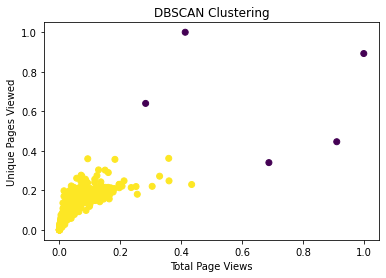

In [12]:
# plot the data
plt.scatter(pages['scale_count'], pages['scale_nunique'], c=pages.labels)
# add labels
plt.xlabel('Total Page Views')
plt.ylabel('Unique Pages Viewed')
plt.title('DBSCAN Clustering')
plt.show();

- Use DBSCAN to detect anomalies in other products from the customers dataset. The database name is grocery_db.

In [13]:
def get_grocery_db():
    if os.path.isfile("grocery_db.csv"):
        return pd.read_csv("grocery_db.csv", index_col=False)
    else:
        # read sql query into dataframe
        url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/grocery_db'
        sql = '''
        SELECT *
        FROM grocery_customers;
        '''
        df = pd.read_sql(sql, url)

        # dataframe to csv
        df.to_csv("grocery_db.csv", index = False)

        return df
# get data    
groceries = get_grocery_db()
groceries.head()


,customer_id,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0,2,3,12669,9656,7561,214,2674,1338
1,1,2,3,7057,9810,9568,1762,3293,1776
2,2,2,3,6353,8808,7684,2405,3516,7844
3,3,1,3,13265,1196,4221,6404,507,1788
4,4,2,3,22615,5410,7198,3915,1777,5185


In [14]:
groceries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   customer_id       440 non-null    int64
 1   Channel           440 non-null    int64
 2   Region            440 non-null    int64
 3   Fresh             440 non-null    int64
 4   Milk              440 non-null    int64
 5   Grocery           440 non-null    int64
 6   Frozen            440 non-null    int64
 7   Detergents_Paper  440 non-null    int64
 8   Delicassen        440 non-null    int64
dtypes: int64(9)
memory usage: 31.1 KB


In [15]:
# Cluster on all or a selected subset of features
frozen_deli_fresh = groceries[["Frozen", "Delicassen", "Fresh"]]
frozen_deli_fresh.head(2)


,Frozen,Delicassen,Fresh
0,214,1338,12669
1,1762,1776,7057


In [16]:
# scale the data using minmax scaler
scaler = MinMaxScaler()
scaler.fit(frozen_deli_fresh)
scaled_frozen_deli_fresh = scaler.transform(frozen_deli_fresh)
scaled_frozen_deli_fresh

array([[0.0031063 , 0.02784731, 0.11294004],
       [0.02854842, 0.03698373, 0.06289903],
       [0.03911643, 0.16355861, 0.05662161],
       ...,
       [0.00677142, 0.03888194, 0.1295431 ],
       [0.01664914, 0.04426366, 0.091727  ],
       [0.00065742, 0.00102211, 0.02482434]])

In [17]:
# DBSCAN clustering
dbs = DBSCAN(eps=0.1, min_samples=4).fit(scaled_frozen_deli_fresh)
print(dbs)

DBSCAN(eps=0.1, min_samples=4)


In [18]:
groceries['Frozen_scaled'] = scaled_frozen_deli_fresh[:, 0]
groceries['Delicassen_scaled'] = scaled_frozen_deli_fresh[:, 1]
groceries['Fresh_scaled'] = scaled_frozen_deli_fresh[:, 2]
groceries

,customer_id,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Frozen_scaled,Delicassen_scaled,Fresh_scaled
0,0,2,3,12669,9656,7561,214,2674,1338,0.003106,0.027847,0.112940
1,1,2,3,7057,9810,9568,1762,3293,1776,0.028548,0.036984,0.062899
2,2,2,3,6353,8808,7684,2405,3516,7844,0.039116,0.163559,0.056622
3,3,1,3,13265,1196,4221,6404,507,1788,0.104842,0.037234,0.118254
4,4,2,3,22615,5410,7198,3915,1777,5185,0.063934,0.108093,0.201626
...,...,...,...,...,...,...,...,...,...,...,...,...
435,435,1,3,29703,12051,16027,13135,182,2204,0.215469,0.045912,0.264829
436,436,1,3,39228,1431,764,4510,93,2346,0.073713,0.048874,0.349761
437,437,2,3,14531,15488,30243,437,14841,1867,0.006771,0.038882,0.129543
438,438,1,3,10290,1981,2232,1038,168,2125,0.016649,0.044264,0.091727


In [19]:
# check the scaled values
groceries.head()

,customer_id,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Frozen_scaled,Delicassen_scaled,Fresh_scaled
0,0,2,3,12669,9656,7561,214,2674,1338,0.003106,0.027847,0.112940
1,1,2,3,7057,9810,9568,1762,3293,1776,0.028548,0.036984,0.062899
2,2,2,3,6353,8808,7684,2405,3516,7844,0.039116,0.163559,0.056622
3,3,1,3,13265,1196,4221,6404,507,1788,0.104842,0.037234,0.118254
4,4,2,3,22615,5410,7198,3915,1777,5185,0.063934,0.108093,0.201626


In [20]:
# look at dbscan array
labels = dbs.labels_
labels[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [21]:
# add the labels to the dataframe
groceries['labels'] = labels

In [22]:
# isolate anomalies
anomalies = groceries[groceries.labels == -1]
anomalies

,customer_id,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Frozen_scaled,Delicassen_scaled,Fresh_scaled,labels
23,23,2,3,26373,36423,22019,5154,4337,16523,0.084298,0.344597,0.235136,-1
47,47,2,3,44466,54259,55571,7782,24171,6465,0.127490,0.134793,0.396467,-1
71,71,1,3,18291,1266,21042,5373,4173,14472,0.087897,0.301815,0.163070,-1
87,87,1,3,43265,5025,8117,6312,1579,14351,0.103330,0.299291,0.385758,-1
93,93,1,3,11314,3090,2062,35009,71,2698,0.574979,0.056216,0.100858,-1
103,103,1,3,56082,3504,8906,18028,1480,2498,0.295888,0.052044,0.500045,-1
125,125,1,3,76237,3473,7102,16538,778,918,0.271399,0.019086,0.679762,-1
181,181,1,3,112151,29627,18148,16745,4948,8550,0.274801,0.178285,1.000000,-1
183,183,1,3,36847,43950,20170,36534,239,47943,0.600043,1.000000,0.328530,-1
284,284,1,3,68951,4411,12609,8692,751,2406,0.142446,0.050125,0.614795,-1


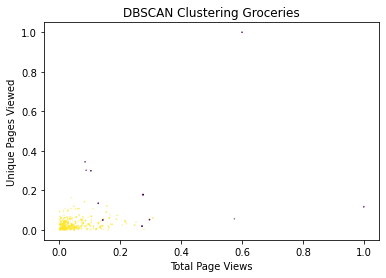

In [23]:
# plot the data
plt.scatter(groceries['Frozen_scaled'], groceries['Delicassen_scaled'], groceries['Fresh_scaled'], c=groceries.labels)
# add labels
plt.xlabel('Total Page Views')
plt.ylabel('Unique Pages Viewed')
plt.title('DBSCAN Clustering Groceries')
plt.show();

- Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).

In [24]:
# acquire zillow data
def get_zillow17_data(use_cache=True):
    filename = "zillow.csv"
    if os.path.isfile(filename) and use_cache:
        print("Let me get that for you...")
        return pd.read_csv(filename)
    print("Sorry, nothing on file, let me create one for you...")
    data = 'zillow'
    url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/{data}'
    query = '''
            SELECT parcelid, bathroomcnt, bedroomcnt, calculatedbathnbr, finishedsquarefeet12, fips, garagecarcnt, latitude, longitude, lotsizesquarefeet, propertycountylandusecode, regionidcounty, yearbuilt, taxvaluedollarcnt, assessmentyear
            FROM properties_2017 p
            LEFT JOIN propertylandusetype USING (propertylandusetypeid)
            LEFT JOIN predictions_2017 USING (parcelid)
            WHERE propertylandusedesc IN ('Single Family Residential');
            '''
    zillow17_data = pd.read_sql(query, url)
    zillow17_data.to_csv(filename)
    return zillow17_data

In [25]:
zillow_df = get_zillow17_data()

Let me get that for you...


In [26]:
zillow_df.head()

,Unnamed: 0,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,finishedsquarefeet12,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,regionidcounty,yearbuilt,taxvaluedollarcnt,assessmentyear
0,0,17173851,2.0,4.0,2.0,1848.0,6111.0,NaN,34153345.0,-119194015.0,11396.0,1110,2061.0,1952.0,64712.0,2016.0
1,1,10821119,2.0,2.0,2.0,1430.0,6037.0,NaN,34217763.0,-118504217.0,6299.0,0101,3101.0,1952.0,381638.0,2016.0
2,2,10903424,3.0,3.0,3.0,1892.0,6037.0,NaN,34162306.0,-118421221.0,8194.0,0100,3101.0,1950.0,568899.0,2016.0
3,3,11007640,2.0,3.0,2.0,1572.0,6037.0,NaN,34326995.0,-118426172.0,8683.0,0100,3101.0,1976.0,305307.0,2016.0
4,4,11267114,1.0,3.0,1.0,936.0,6037.0,NaN,34664089.0,-118199524.0,6881.0,0100,3101.0,1970.0,112545.0,2016.0


In [27]:
# select feature for dbscan clustering
sqft_br = zillow_df[["bedroomcnt", "finishedsquarefeet12"]]

In [28]:
# drop null values
sqft_br = sqft_br.dropna()

In [29]:
# scale the data using minmax scaler
scaler = MinMaxScaler()
scaler.fit(sqft_br)
scaled_sqft_br = scaler.transform(sqft_br)

In [30]:
dbs = DBSCAN(eps=0.1, min_samples=4).fit(scaled_sqft_br)

In [ ]:
sqft_br['bedroomcnt'] = scaled_sqft_br[:, 0]
sqft_br['finishedsquarefeet12'] = scaled_sqft_br[:, 1]

In [ ]:
labels = dbs.labels_
labels[0:10]

In [ ]:
# add the labels to the dataframe
sqft_br['labels'] = labels

In [ ]:
anomalies = sqft_br[sqft_br.labels == -1]
anomalies

In [ ]:
# plot the data
plt.scatter(sqft_br['bedroomcnt'], sqft_br['finishedsquarefeet12'], c=sqft_br.labels)
# add labels
plt.xlabel('Total sqft and bedrooms')
plt.ylabel('Unique sqft and bedrooms')
plt.title('DBSCAN Clustering Zillow')
plt.show();